In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv
/kaggle/input/santander-customer-transaction-prediction-dataset/test.csv


In [2]:
pd.options.display.max_info_rows = 201
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style = "darkgrid")
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier


In [3]:
# ingest the dataset

raw_dataset = pd.read_csv("../input/santander-customer-transaction-prediction-dataset/train.csv")
raw_dataset.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
# See the rough distribution of data 
raw_dataset.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [5]:
#See number of nulls 
raw_dataset.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 202 columns):
 #    Column   Non-Null Count   Dtype  
---   ------   --------------   -----  
 0    ID_code  200000 non-null  object 
 1    target   200000 non-null  int64  
 2    var_0    200000 non-null  float64
 3    var_1    200000 non-null  float64
 4    var_2    200000 non-null  float64
 5    var_3    200000 non-null  float64
 6    var_4    200000 non-null  float64
 7    var_5    200000 non-null  float64
 8    var_6    200000 non-null  float64
 9    var_7    200000 non-null  float64
 10   var_8    200000 non-null  float64
 11   var_9    200000 non-null  float64
 12   var_10   200000 non-null  float64
 13   var_11   200000 non-null  float64
 14   var_12   200000 non-null  float64
 15   var_13   200000 non-null  float64
 16   var_14   200000 non-null  float64
 17   var_15   200000 non-null  float64
 18   var_16   200000 non-null  float64
 19   var_17   200000 non-null  float64
 20   va

In [6]:
# Get binary class distribution
raw_dataset["target"].value_counts(dropna = False)/raw_dataset.shape[0]

#highly skewed distribution

0    0.89951
1    0.10049
Name: target, dtype: float64

In [7]:
# #get distribution
# raw_dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize = (20,18));

# # Except target, most of the variables are normally distributed

In [8]:
# get box and whisker plots 

# plt.boxplot(raw_dataset, labels = list(raw_dataset.columns));


In [9]:
# # corr matrix 

# fig = plt.figure(figsize = (20,18))
# ax = fig.add_subplot(111)
# cax = ax.matshow(raw_dataset.corr(), vmin=-1, vmax=1, interpolation='none')
# fig.colorbar(cax)
# plt.show()

# #low correlation between attributes

In [10]:
# #Get correlation matrix

# corr_matrix = raw_dataset.corr().abs()

# #low correlation between attributes

In [11]:
# # Check if any cols are more correlated 

# correlation_treshold = 0.6

# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# correlated_cols = [column for column in upper.columns if any(upper[column] > correlation_treshold)]

# correlated_cols

In [12]:
# Get a stratified sampling 1% of the data to run algos

sampled_data = raw_dataset.groupby("target", group_keys=False).apply(lambda x: x.sample(frac=0.01))


#check distribution
sampled_data["target"].value_counts(dropna = False)/sampled_data.shape[0]


0    0.8995
1    0.1005
Name: target, dtype: float64

In [13]:
# Seperate features and target
sampled_data.reset_index(inplace = True)
X = sampled_data.drop(columns = ["ID_code", "target"])
y = sampled_data["target"]

In [14]:
# Initialize a stratified k fold validation instance

num_folds = 10
random_seed = 42

skf = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_seed)

In [15]:
# Get a baseline benchmark using Zero Rule Classification

def zero_rule_classification(train, test):
    prediction = stats.mode(train_y)[0][0]
    predicted = [prediction for i in range(len(test))]
    return predicted

splits = skf.split(X, y)
acc_list = list()

for train_index, test_index in splits:
    train_y = y[train_index]
    test_y = y[test_index]
    predicted = zero_rule_classification(train_y, test_y)
    acc_list.append(
        accuracy_score(test_y, predicted)
    )
    
print("benchmark zero classification mean accuracy: {mean_acc}".format(mean_acc = round(np.mean(acc_list),4)))
        

benchmark zero classification mean accuracy: 0.8995


In [16]:
# Get a list of candidate algos that we want to test

models = list()
models.append(
    ("LR", LogisticRegression())
)
models.append(
    ("LD", LinearDiscriminantAnalysis())
)
models.append(
    ("SGD", SGDClassifier())
)
models.append(
    ("KNN", KNeighborsClassifier())
)
models.append(
    ("CART", DecisionTreeClassifier())
)
models.append(
    ("NB", GaussianNB())
)
models.append(
    ("SVC", SVC())
)


In [17]:
# Get an intial testing harness for candidate algos NO SCALING

results = list()
model_name = list()
scoring = "accuracy"

for name, model in models:
    
    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
    cv_results = cross_val_score(model, X, y, cv = skfold, scoring= scoring)
    results.append(cv_results)
    model_name.append(name)
    print(
        "{name} avg. accuracy: {mean} std: {std}".format(
            name = name,
            mean = round(cv_results.mean(),3),
            std = round(cv_results.std(),3) 
    ))
    
# Pass 1 : LR The train set failed to converge meaning the the input data is not scaled properly and CART and SGD have bigger spead of scores 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR avg. accuracy: 0.887 std: 0.008
LD avg. accuracy: 0.895 std: 0.017
SGD avg. accuracy: 0.738 std: 0.319
KNN avg. accuracy: 0.892 std: 0.006
CART avg. accuracy: 0.818 std: 0.022
NB avg. accuracy: 0.901 std: 0.005
SVC avg. accuracy: 0.9 std: 0.002


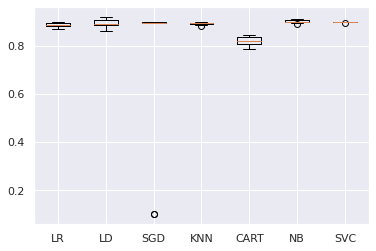

In [18]:
# Plot the distribution of the algos

plt.boxplot(results, labels = model_name);

In [19]:
# Add a scaling step

results = list()
model_name = list()
scoring = "accuracy"

for name, model in models:
    
    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
    model_pipeline = Pipeline([
        ("scaler", StandardScaler()),(name, model)
    ])
    cv_results = cross_val_score(model_pipeline, X, y, cv = skfold, scoring= scoring)
    results.append(cv_results)
    model_name.append(name)
    print(
        "{name} avg. accuracy: {mean} std: {std}".format(
            name = name,
            mean = round(cv_results.mean(),3),
            std = round(cv_results.std(),3) 
    ))

# Pass 2 : Scale the input 
#LR converged after scaling

LR avg. accuracy: 0.888 std: 0.021
LD avg. accuracy: 0.895 std: 0.017
SGD avg. accuracy: 0.877 std: 0.022
KNN avg. accuracy: 0.9 std: 0.002
CART avg. accuracy: 0.822 std: 0.015
NB avg. accuracy: 0.904 std: 0.014
SVC avg. accuracy: 0.9 std: 0.002


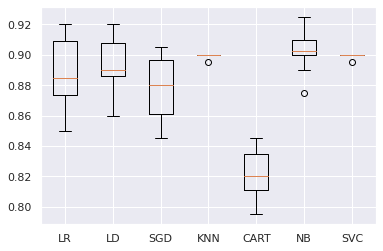

In [20]:
# Plot the distribution of the algos

plt.boxplot(results, labels = model_name);

In [21]:
# Based on the inital result LR, LD, NB and SVC perform better than a zero classification model

# Tuning LR with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X)
rescaledX = scaler.transform(X)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
max_iter = [200, 300]
c_values = [1.0, 0.1, 0.01, 0.001]

model_params = dict(solver = solvers, max_iter = max_iter, C = c_values)
skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = LogisticRegression()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best 0.9077999999999999 using {'C': 0.01, 'max_iter': 200, 'solver': 'newton-cg'}

Best 0.9039999999999999 using {'C': 0.001, 'max_iter': 200, 'solver': 'liblinear'}
0.888500 (0.021453) with: {'C': 1.0, 'max_iter': 200, 'solver': 'newton-cg'}
0.888500 (0.021453) with: {'C': 1.0, 'max_iter': 200, 'solver': 'lbfgs'}
0.888000 (0.021000) with: {'C': 1.0, 'max_iter': 200, 'solver': 'liblinear'}
0.888500 (0.021453) with: {'C': 1.0, 'max_iter': 300, 'solver': 'newton-cg'}
0.888500 (0.021453) with: {'C': 1.0, 'max_iter': 300, 'solver': 'lbfgs'}
0.888000 (0.021000) with: {'C': 1.0, 'max_iter': 300, 'solver': 'liblinear'}
0.896000 (0.019975) with: {'C': 0.1, 'max_iter': 200, 'solver': 'newton-cg'}
0.896000 (0.019975) with: {'C': 0.1, 'max_iter': 200, 'solver': 'lbfgs'}
0.897500 (0.019138) with: {'C': 0.1, 'max_iter': 200, 'solver': 'liblinear'}
0.896000 (0.019975) with: {'C': 0.1, 'max_iter': 300, 'solver': 'newton-cg'}
0.896000 (0.019975) with: {'C': 0.1, 'max_iter': 300, 'solver': 'lbfgs'}
0.897500 (0.019138) with: {'C': 0.1, 'max_iter': 300, 'solver': 'liblinear'}
0.903000 

In [22]:
# Tuning NB with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X)
rescaledX = scaler.transform(X)

var_smoothing =  np.logspace(0,-9, num=100)
    
model_params = dict(var_smoothing = var_smoothing)
skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = GaussianNB()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Best 0.9165000000000001 using {'var_smoothing': 0.02848035868435802}

Best 0.908 using {'var_smoothing': 0.0657933224657568}
0.899500 (0.001500) with: {'var_smoothing': 1.0}
0.899500 (0.001500) with: {'var_smoothing': 0.8111308307896871}
0.899000 (0.002000) with: {'var_smoothing': 0.657933224657568}
0.899000 (0.002000) with: {'var_smoothing': 0.533669923120631}
0.900500 (0.002693) with: {'var_smoothing': 0.43287612810830584}
0.902000 (0.004000) with: {'var_smoothing': 0.3511191734215131}
0.902500 (0.003354) with: {'var_smoothing': 0.2848035868435802}
0.902000 (0.004000) with: {'var_smoothing': 0.23101297000831597}
0.903000 (0.005568) with: {'var_smoothing': 0.1873817422860384}
0.907000 (0.005568) with: {'var_smoothing': 0.15199110829529336}
0.907000 (0.005568) with: {'var_smoothing': 0.12328467394420659}
0.906500 (0.007433) with: {'var_smoothing': 0.1}
0.907500 (0.006423) with: {'var_smoothing': 0.08111308307896872}
0.908000 (0.006782) with: {'var_smoothing': 0.0657933224657568}
0.905000 (0.007416) with: {'var_smoothing': 0.0533669923120631}
0.905000 (0.

In [23]:
# Tuning LD with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X)
rescaledX = scaler.transform(X)

solver = ['svd', 'lsqr', 'eigen']
model_params = dict(solver=solver)

skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = LinearDiscriminantAnalysis()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best 0.9127000000000001 using {'solver': 'svd'}

Best 0.8950000000000001 using {'solver': 'svd'}
0.895000 (0.017321) with: {'solver': 'svd'}
0.895000 (0.017321) with: {'solver': 'lsqr'}
0.895000 (0.017321) with: {'solver': 'eigen'}


In [24]:
# Tuning SVC with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X)
rescaledX = scaler.transform(X)

kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
c_values = [0.1,1,2,3,5,8,11]
model_params = dict(C=c_values, kernel = kernel_values)

skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = SVC()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best 0.9119999999999999 using {'C': 2, 'kernel': 'sigmoid'}

Best 0.9014999999999999 using {'C': 3, 'kernel': 'rbf'}
0.888000 (0.020273) with: {'C': 0.1, 'kernel': 'linear'}
0.899500 (0.001500) with: {'C': 0.1, 'kernel': 'poly'}
0.899500 (0.001500) with: {'C': 0.1, 'kernel': 'rbf'}
0.899500 (0.001500) with: {'C': 0.1, 'kernel': 'sigmoid'}
0.885500 (0.019164) with: {'C': 1, 'kernel': 'linear'}
0.899500 (0.001500) with: {'C': 1, 'kernel': 'poly'}
0.899500 (0.001500) with: {'C': 1, 'kernel': 'rbf'}
0.899500 (0.001500) with: {'C': 1, 'kernel': 'sigmoid'}
0.885000 (0.020976) with: {'C': 2, 'kernel': 'linear'}
0.899500 (0.001500) with: {'C': 2, 'kernel': 'poly'}
0.900500 (0.004717) with: {'C': 2, 'kernel': 'rbf'}
0.900000 (0.006325) with: {'C': 2, 'kernel': 'sigmoid'}
0.885500 (0.022074) with: {'C': 3, 'kernel': 'linear'}
0.899500 (0.001500) with: {'C': 3, 'kernel': 'poly'}
0.901500 (0.004500) with: {'C': 3, 'kernel': 'rbf'}
0.899000 (0.008888) with: {'C': 3, 'kernel': 'sigmoid'}
0.885000 (0.021213) with: {'C': 5, 'kernel': 'linear'}
0.899500 (0.00150

In [25]:
# Test out ensemble methods on the dataset 
ensembles = list()
ensembles.append(
    ("AB", AdaBoostClassifier())
)
ensembles.append(
    ("GD", GradientBoostingClassifier())
)
ensembles.append(
    ("RT", RandomForestClassifier())
)
ensembles.append(
    ("ET", ExtraTreesClassifier())
)


In [26]:
# Add a scaling step to the ensembles
results = list()
ensemble_name = list()
scoring = "accuracy"

for name, ensemble in ensembles:
    
    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
    model_pipeline = Pipeline([
        ("scaler", StandardScaler()),(name, ensemble)
    ])
    cv_results = cross_val_score(model_pipeline, X, y, cv = skfold, scoring= scoring)
    results.append(cv_results)
    model_name.append(name)
    print(
        "{name} avg. accuracy: {mean} std: {std}".format(
            name = name,
            mean = round(cv_results.mean(),3),
            std = round(cv_results.std(),3) 
    ))

# Pass 2 : Scale the input 
#LR still not converging 

AB avg. accuracy: 0.893 std: 0.013
GD avg. accuracy: 0.894 std: 0.008
RT avg. accuracy: 0.9 std: 0.002
ET avg. accuracy: 0.9 std: 0.002


In [27]:
# Slect a fw best algos and apply SMOTE to improve


In [28]:
#Change scoring metric to emphasise on precision and recall 